In [1]:
## importing the required packages

from qiskit import *
from qiskit.tools.visualization import *
from qiskit.circuit import quantumcircuit
import numpy as np


<h1><center>Solving the Lights Out Puzzle Using Grover's Algorithm</center></h1>

<h3><center>CIE470</center></h3>
<h3><center>Introduction to Quantum Information and Computation</center></h3>


<h2><center>Mohamed Hatem Saleh</center></h2>
<h2><center>202001235</center></h2>

## Problem description:
The Puzzle consists of an NxN grid of bulbs, where each bulb occupied a cell on the grid, and has its own switch, which when pressed switches the state of the bulb between "on <----> off" ***and the state of the vertically and horizontally adjacent bulbs***. The grid starts off in an initial state of on-&-off bulbs, and you need to find the sequence of switch presses that would "turn off all the lights", hence the name, "Lights-Out-Puzzle".  


###### It could be applied on any square dimension, but in our case we Consider the initial state in the picture attached in the file with 9 bulbs, with yellow meaning the coresponding bulb is on, this is the setup we will have to solve for. This corresponds to initial state :[0, 1, 1, 0, 0, 1, 1, 0, 0]

In [2]:
N_bulbs = 9
lights = [0, 1, 1, 0, 0, 1, 1, 0, 0]

In [3]:
# function to map the indices of the vector into matrix
def initialize_square_matrix(N):
    matrix = [[0] * N for _ in range(N)]
    value = 0
    for i in range(N):
        for j in range(N):
            matrix[i][j] = value
            value += 1
    return matrix

index_matrix = initialize_square_matrix(np.sqrt(N_bulbs).astype(int))

In [4]:
# fuction the return the neighobrs affected while switching
def get_neighbors(row, col, matrix =index_matrix):
    neighbors = []
    rows, cols = len(matrix), len(matrix[0])
    # 4 neighbors (top, bottom, left, right)
    offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    for offset in offsets:
        r, c = row + offset[0], col + offset[1]
        if 0 <= r < rows and 0 <= c < cols:
            neighbors.append(matrix[r][c])

    return neighbors

### Q1: Register preparation :
A. Register Preparation: we need to setup the quantum and classical registers for the problem, which involves using 3 main quantum-registers and a classical-register.

1.   A register to hold the solution space of switch-states, since the solution to the problem is a set of 9 on/off(binary system) switches (we have a 3x3 grid of bulbs), call this register "switch/var". NB: remember a switch can be on or off (binary, and we can only flip a switch once), we therefore have  29  possible states forming our state-space of possible solutions, a perfect candidate for mapping to a 9-qubit system.

2.   A control register which will carry temporary info about the state of the bulbs (bulb-states), and be used to determine if a given switch-state is a solution, call it "bulb/ctrl"

3. An output qubit which will initiate a phase kickback if the control register (representing the bulb-states) reflects that a given switch-state is a solution.
A classical register to store the measurements

In [5]:
switch = QuantumRegister(9,'switch')
bulb = QuantumRegister(9,'bulb')
output = QuantumRegister(1,'output')
results = ClassicalRegister(9,'Measurement')

qc = QuantumCircuit(switch, bulb, output, results)

In [6]:
# show the 19 qubits initialized for the algo
qc.draw(cregbundle= False)


switch_0: 
               
     switch_1: 
               
     switch_2: 
               
     switch_3: 
               
     switch_4: 
               
     switch_5: 
               
     switch_6: 
               
     switch_7: 
               
     switch_8: 
               
       bulb_0: 
               
       bulb_1: 
               
       bulb_2: 
               
       bulb_3: 
               
       bulb_4: 
               
       bulb_5: 
               
       bulb_6: 
               
       bulb_7: 
               
       bulb_8: 
               
       output: 
               
Measurement_0: 
               
Measurement_1: 
               
Measurement_2: 
               
Measurement_3: 
               
Measurement_4: 
               
Measurement_5: 
               
Measurement_6: 
               
Measurement_7: 
               
Measurement_8:

### Q2: Iterations can be determined by :

Q2: Describe how we determine the number of iterations and set the number of iterations for our case:

The number of iterations depends on the Number of the Qubits and could be calculated as following equation, then take the integar value of the result: $$T = \frac{\pi}{4} \sqrt{2^n} -\frac{1}{2}$$  

In our case the n = 9, then T = 17




In [7]:
## initialize the iterations variable
iterations = int(np.pi/4*np.sqrt(2**N_bulbs)-0.5)
iterations

17

### Q3: Circuit initialization for the given lights-out setup :


*   The whole qubits representing the bulbs are initialized with zero, so the following for loop gets the ones bits and apply NOT gate on the their coresponding qubits to to flip to |1>
*   Apply Hadmard on the the switches to convert them from |0> tensor n into (|0> + |1>)tensor n to get the 2^n combinations for switching.
*   Convert the output into |-> state to be used for phase kickback of the winner changes  



In [8]:
def initialize(lights, qc, qr):
  # lights is the classical input bits
  # qc the designed circuits
  # qr is the bulb state

  # initilize the bulbs
  j = 0
  for i in lights:
      if i==1:
          qc.x(qr[j])
      j += 1
  # get the 2^9 possible cases
  qc.h(switch)
  # initialize the state of the output qubit for phase kickback
  # convert output into |->
  qc.x(output[0])
  qc.h(output[0])

In [9]:
# show the initialization circuit
initialize(lights,qc,bulb)

qc.draw(cregbundle= False)


┌───┐     
     switch_0: ┤ H ├─────
               ├───┤     
     switch_1: ┤ H ├─────
               ├───┤     
     switch_2: ┤ H ├─────
               ├───┤     
     switch_3: ┤ H ├─────
               ├───┤     
     switch_4: ┤ H ├─────
               ├───┤     
     switch_5: ┤ H ├─────
               ├───┤     
     switch_6: ┤ H ├─────
               ├───┤     
     switch_7: ┤ H ├─────
               ├───┤     
     switch_8: ┤ H ├─────
               └───┘     
       bulb_0: ──────────
               ┌───┐     
       bulb_1: ┤ X ├─────
               ├───┤     
       bulb_2: ┤ X ├─────
               └───┘     
       bulb_3: ──────────
                         
       bulb_4: ──────────
               ┌───┐     
       bulb_5: ┤ X ├─────
               ├───┤     
       bulb_6: ┤ X ├─────
               └───┘     
       bulb_7: ──────────
                         
       bulb_8: ──────────
               ┌───┐┌───┐
       output: ┤ X ├┤ H ├
               └───┘└───┘
Measurement_0: ══════════
                         
Measurement_1: ══════════
                         
Measurement_2: ══════════
                         
Measurement_3: ══════════
                         
Measurement_4: ══════════
                         
Measurement_5: ══════════
                         
Measurement_6: ══════════
                         
Measurement_7: ══════════
                         
Measurement_8: ══════════

### C. Construct the problem Oracle:

Q4: We need to define a function for the first part of the oracle below, which takes the prepared quantum circuit, some switch state, and the given initial bulb-state, and finally acts on the bulb-state accordingly.

### This function works in both directions, fliping the bulbs states and uncomputing that action
*  Decide the direction of the function to set the range of the for loop
*  Get the index of the bulb as if it was in matrix form to make getting the neighbors easier
*  Get the neighbors and the flip their state according to the value of the switche
*  Flipe the state of the qubit itself (before/after) the neighbors based on the direction according to the value of the switche

In [10]:
# what flipping every switch does to the bulb-state
def switch_flip(qc,switch,bulb,N_bulbs,direction=0):
  # qc: the designed circuit
  # switch: represent if the state of the bulb will be fliped or not
  # blub: reg of the bulbs states
  # N_bulb: number of bulbs
  # direction: represent if fn is used for fliping or uncomputing

  n = (np.sqrt(N_bulbs)).astype(int)

  if direction == 0:
    my_range = range(N_bulbs)
  else:
    my_range = reversed(range(N_bulbs))

  for i in my_range:
    row = i // n
    col = i % n
    '--------------------switch itself-----------------------'
    if direction == 0 :
      qc.cx(switch[i], bulb[i])
    '------------------switch neighbors----------------------'
    neighbors_index = get_neighbors(row,col)
    for j in neighbors_index:
      qc.cx(switch[i], bulb[j])
    '------------------uncompute itself-----------------------'
    if direction == 1:
      qc.cx(switch[i], bulb[i])


#### Q5a: Complete the for loop below which runs our predetermined iterations of Grover.
-applies the first part of the oracle (by calling a function)  
-applies the second part of the oracle to check for the winner switch-state (Hint: a known gate can do this):  
Apply NOT gate on the the whole bulbs to convert the target state |0> tensor n into ones to activate the multi-controlled toffoli gate to flip the phase (sign) of the output qubit "the target", then apply NOT gate again to get the bulbs back to their states

-uncomputes (you should know what that is):
apply the switch flip function but in reverse direction to free the qubits from the entangelment occured between the switches and the bulbs. Uncomputation also can lead to more efficient quantum circuits. By undoing unnecessary operations, we reduce the number of gates and qubits required.
-applies an appropriate diffuser  
It is used to amplify the solution probablity over the iterations to be most likely to be our soltuion

In [11]:
def diffusion(qc,switch):
  qc.h(switch)
  qc.x(switch)
  qc.h(switch[-1])
  qc.mct(switch[0:-1], switch[-1])
  qc.h(switch[-1])
  qc.x(switch)
  qc.h(switch)

In [12]:
for i in range(iterations):
    '--------------------oracle-----------------------'
    # apply switch
    switch_flip(qc,switch,bulb,N_bulbs,0)
    # check for winners, and apply phase kick-back
    qc.x(bulb)
    qc.mct(bulb, output)
    qc.x(bulb)
    # Uncompute
    switch_flip(qc,switch,bulb,N_bulbs,1)

    '-------------------diffusion----------------------'
    diffusion(qc,switch)



<ipython-input-12-3429249b4511>:7: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(bulb, output)
<ipython-input-11-72a4c5fb71a1>:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(switch[0:-1], switch[-1])


#### Q5b: finally measure the output
Measure the switch-states from which we can infer the most probable answer.

NB:  you can use the "qc.reverse_bits()" function on a "qc"-quantum circuit object to reverse the order of the bits to avoid Qiskit's annoying convention.

Apply Measurement on the switches and sore the result in the classical register to represent the soultion.

reverse the bits, because qiskits represent the bits in a reverse order

use the qasm_simulator with 1000 shots to simulate the reuslts of the Algorithm, then get the soultion the max counts

In [13]:
# Measuremnt
qc.measure(switch,results)

# reverse the order as default cuz qiskit is stupid.
qc = qc.reverse_bits()

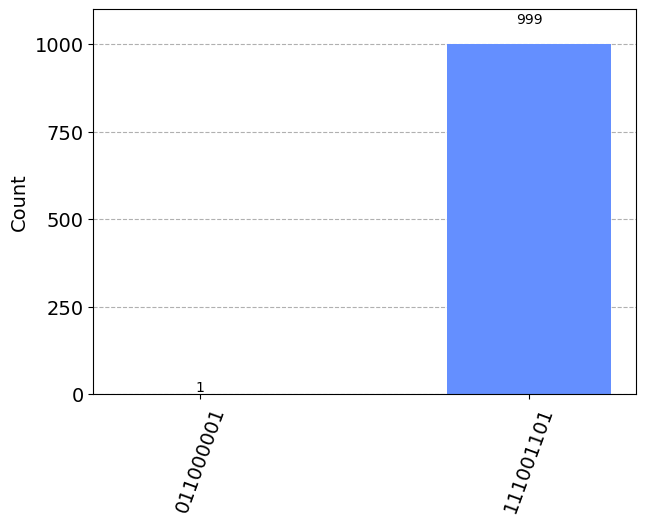

In [14]:
sim = Aer.get_backend('qasm_simulator')

job = execute(qc, backend=sim, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [15]:
score_sorted = sorted(counts.items(), key=lambda x:x[1], reverse=True)
final_solution = score_sorted[0][0]
final_solution

'111001101'

### Final Remarks: Wrap up your steps, talk briefly about your code and summarize the results and conclusion:  

*  Calculated the required T of itreration for the 9 bulbs case
*  Inilization of the bulbs, output and the switches
*  flip_switches that flip the bulbs according the switches states
*  check for the winners, then apply phase kick-back
*  Uncompute the switches effects
*  Amplife the solution probality
*  iterate again till reach the final solutions
*  Slesct the solution with the max counts

The result represent tha appling '111001101' comination of the switches will lead to off the the whole bulbs based on the given initia state

Conclusion:

Grover algorithm could solve the the Lights Out Puzzle in only $$ (\frac{\pi}{4} \sqrt{2^n} -\frac{1}{2}) iterations$$  using the superposition between the whole combination of the switches and the entaglment between the switches and bulbs, in addition to difussion to reduce the complexity of such problems to be O(N^0.5)